In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
import importlib
import Clustering, Forecasting
importlib.reload(Clustering)
importlib.reload(Forecasting)

<module 'Forecasting' from '/home/anna/Desktop/MSU/научка/git/time_series/Forecasting.py'>

In [3]:
data = pd.read_csv("DataSet2.csv", sep=";")#, parse_dates=['Timestamp']) #, nrows=10)

In [63]:
K = 10
df = data.groupby(data.index // K).mean() #усреднение
df_np = df.to_numpy()

In [25]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError, MeanAbsolutePercentageError
from sklearn.metrics import mean_absolute_error as mae
mase = MeanAbsoluteScaledError(multioutput='raw_values')
mase_uni = MeanAbsoluteScaledError(multioutput='uniform_average')
mape = MeanAbsolutePercentageError(multioutput='raw_values')
# mae = MeanAbsoluteError()


#if ‘raw_values’, returns a full set of errors in case of multioutput input. If ‘uniform_average’, errors of all outputs are averaged with uniform weight.

In [6]:
window_sizes_for_clustering = [1, 2, 3, 10]
Ns_clusters = [2, 5, 7, 9, 11]

In [7]:
Ns_clusters = [2]
window_sizes_for_clustering = [1]

In [23]:
dataset = df_np[:100000, ...]

In [71]:
from collections import defaultdict


clusters_labels.shape=(99999,)
N_clusters=2, 2, 34, (21, 67)
Before prediction: train_X.shape=(6, 10, 67), train_y.shape=(6, 67), test_X.shape=(2, 10, 67), test_y.shape=(2, 67)
1/1 [==============================] - 0s 18ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(2, 67), test_y.shape=(2, 67)


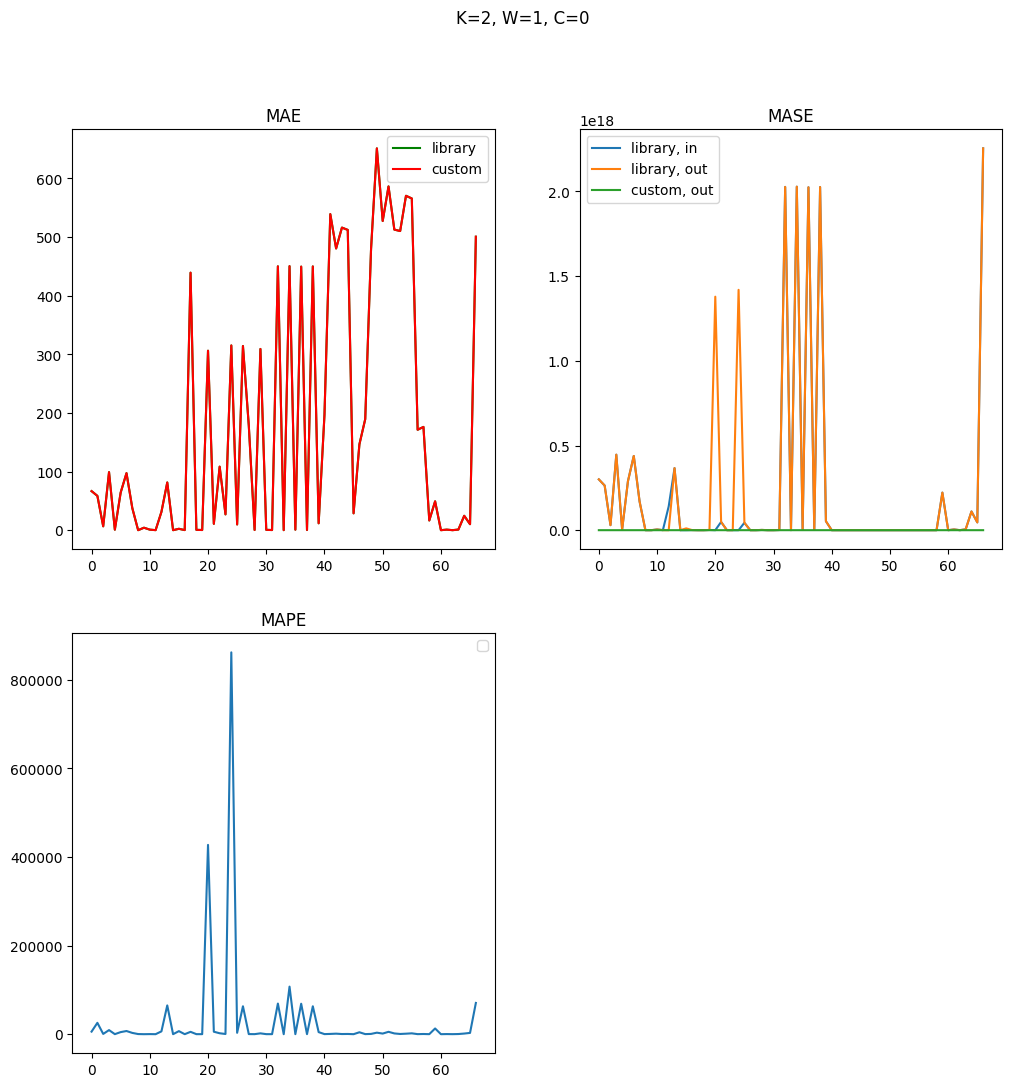

MASE in_sample = [3.00103110e+17 2.63623176e+17 2.97056715e+16 4.45884843e+17
 3.88702423e+15 2.89356500e+17 4.38420815e+17 1.69323612e+17
 2.21681451e+13 1.11338131e+00 4.15879448e+15 3.64219217e+14
 1.40732132e+17 3.66510265e+17 0.00000000e+00 8.05019029e-01
 7.08586010e+14 5.69175014e+02 3.85396022e+01 1.34550348e+15
 7.22447660e+02 4.87859536e+16 9.90001075e+02 2.79865869e+01
 5.45739650e+04 4.39636268e+16 9.18307126e+04 2.41073324e+03
 1.58167144e+15 2.11832056e+03 2.82969326e+01 1.13365898e+15
 2.02708566e+18 1.82211374e+14 2.02850227e+18 3.92523444e+15
 2.02494571e+18 1.44407710e+15 2.02634596e+18 5.29229566e+16
 1.08082932e+03 2.83478254e+03 1.42862068e+03 6.35594425e+02
 7.93176488e+03 4.80076980e+01 1.48917409e+02 3.97408110e+02
 1.75509118e+03 2.97632491e+03 5.87131002e+03 1.68773460e+03
 4.17229532e+03 3.60301615e+03 8.60743523e+02 7.73463603e+03
 7.63963132e+02 1.66608149e+02 1.22883141e+02 2.21810875e+17
 2.65156223e+13 4.26762566e+15 1.35329092e+14 4.86554935e+15
 1.1056

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

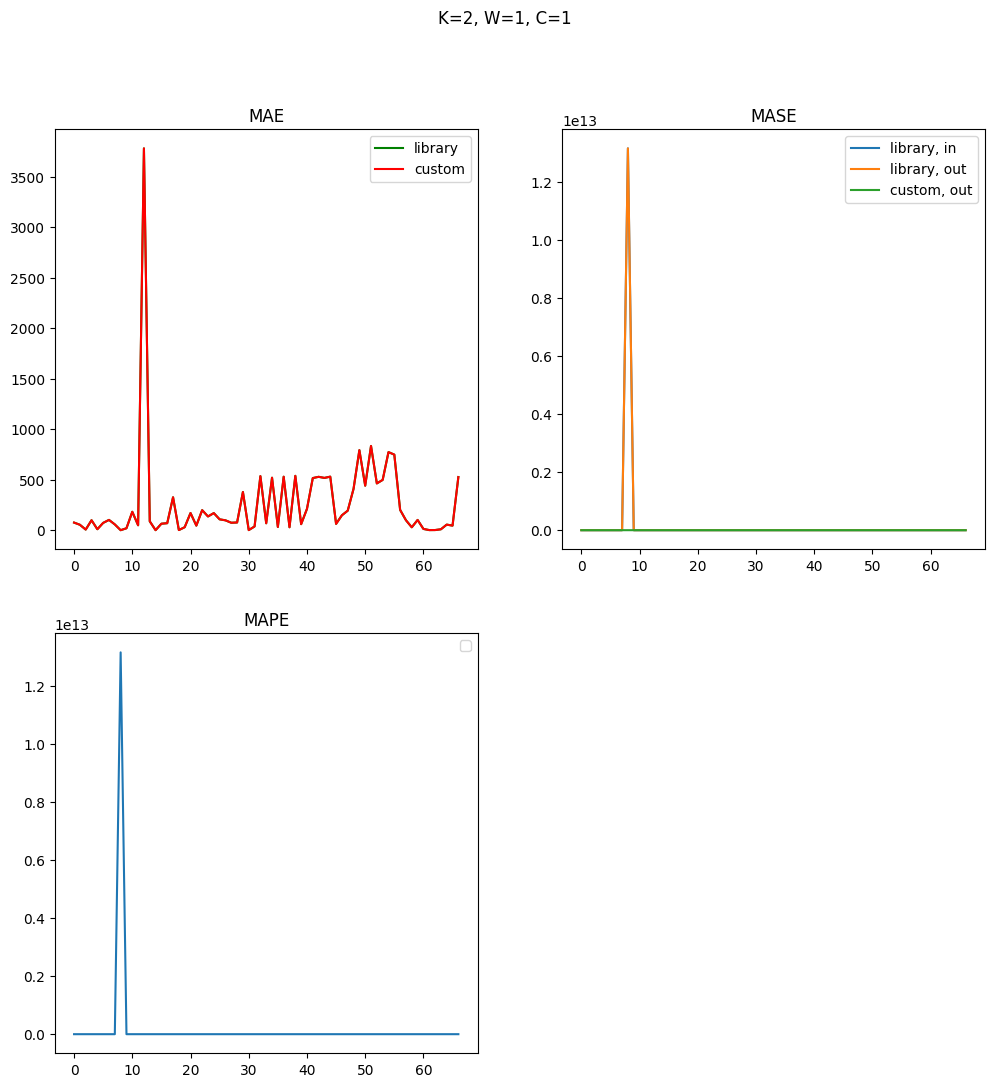

MASE in_sample = [1.47219377e+03 6.84172868e+02 9.54945684e+01 2.47265613e+03
 1.83333197e+01 3.97651137e+02 2.34820875e+03 1.42212680e+02
 1.31505109e+13 8.26922030e+01 1.37639016e+04 4.36472786e+01
 4.19829348e+03 1.16332061e+02 0.00000000e+00 5.39169112e+02
 1.02318742e+02 1.04409207e+03 1.87231550e+00 3.40984974e+02
 2.48351301e+02 9.25885424e+01 2.76448916e+02 4.23458200e+02
 2.40880402e+02 1.56238595e+02 1.63977041e+02 1.48182612e+02
 1.61828608e+02 9.74285798e+02 1.75591408e+00 5.82012572e+01
 6.07951508e+03 1.11838380e+02 6.08010917e+03 5.17763728e+01
 9.33254504e+03 5.39512068e+01 8.71961758e+03 1.19453997e+02
 7.29633750e+03 7.26050782e+02 8.35083755e+02 9.53852527e+02
 1.19317604e+03 2.54917863e+02 1.41556068e+02 2.31268751e+02
 1.02782932e+03 6.11865523e+02 1.07492193e+03 7.68999963e+02
 1.06759364e+03 1.21911275e+03 7.73336983e+02 8.93632739e+02
 1.78534178e+02 1.05883167e+02 5.94239178e+01 2.38899844e+02
 1.16152280e+02 8.53959474e+00 2.52527731e+01 1.11254332e+02
 1.2482

<Figure size 640x480 with 0 Axes>

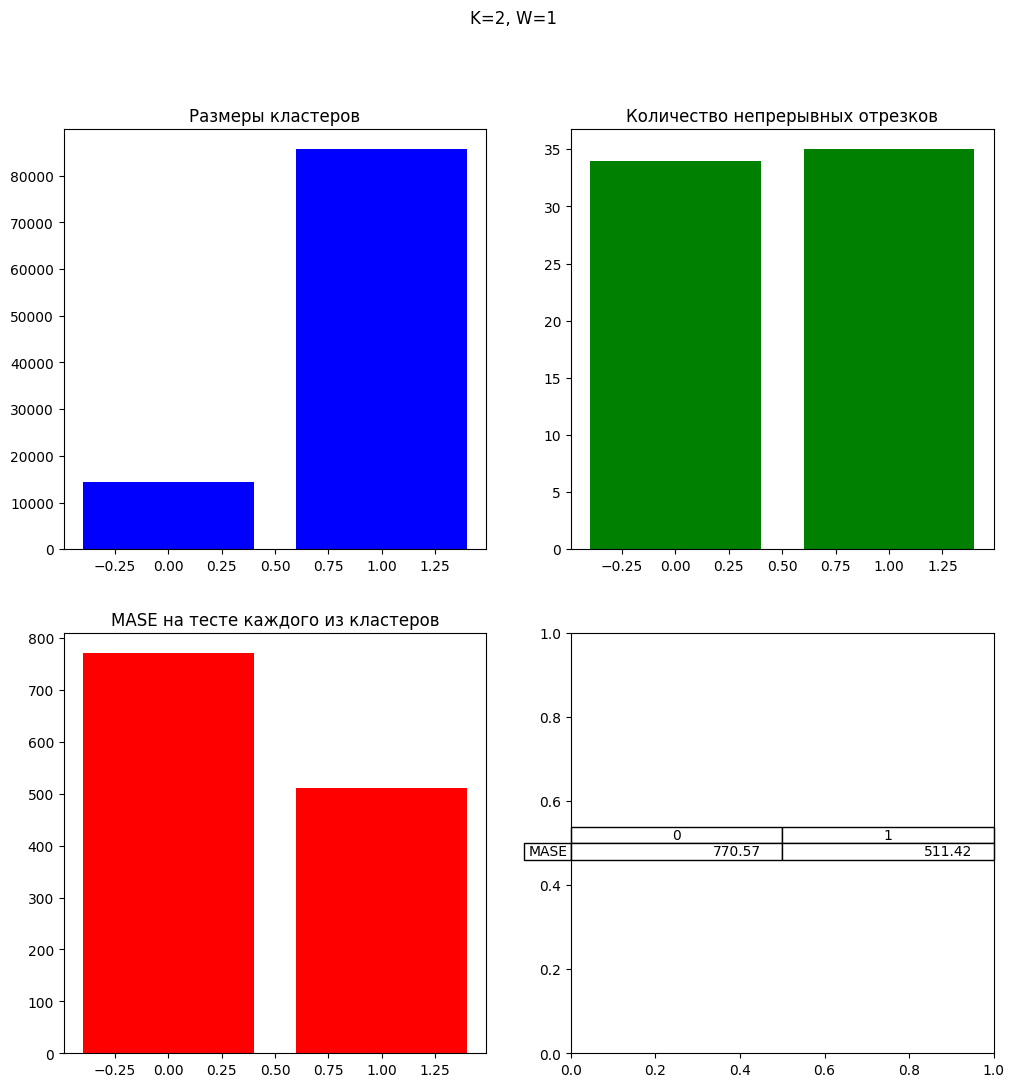

<Figure size 640x480 with 0 Axes>

In [72]:
maes = defaultdict(lambda: [])
mases = defaultdict(lambda: [])
mapes = defaultdict(lambda: [])
answers = {}

for window_size in window_sizes_for_clustering:
    for N_clusters in Ns_clusters:
        dataset_windows, dataset_y = Forecasting.create_windows(dataset, window_size=window_size)
        clusters_labels = Clustering.KMeans_for_windows(dataset_windows, W=window_size, N_clusters=N_clusters, max_iter=50)
        print(f"{clusters_labels.shape=}")
        datasets_clusters = Clustering.flatten_from_interceting_windows(dataset_windows, clusters_labels, W=window_size, \
                N_clusters=N_clusters)
        # list of list of ndarrays [N_i, Q], dataset_clusters[cluster_num][i] - i-th part of dataset for cluster_num

        print(f"{N_clusters=}, {len(datasets_clusters)}, {len(datasets_clusters[0])}, {datasets_clusters[0][0].shape}")
        ###window_size for model
        errors = [1] * N_clusters
        for cluster_num in range(N_clusters):
            sc = Forecasting.MyStandardScaler()
            #datasets_clusters[cluster_num] - list of [N_i, Q] ndarrays
            sc.fit(datasets_clusters[cluster_num])
            prepared_data = sc.transform(datasets_clusters[cluster_num])
            data_X, data_y = Forecasting.create_windows(prepared_data, window_size=10)
            #data_X - list of [N_i-W, W, Q] ndarrays
            train_X, train_y, valid_X, valid_y, test_X, test_y, ind = Forecasting.split_to_train_test(data_X, data_y, part_of_test=0.2, part_of_valid=0.2)
            #ndarrays [N_i, W, Q] or [N_i, Q]
            ind = np.array(ind) + window_size
            print(f"Before prediction: {train_X.shape=}, {train_y.shape=}, {test_X.shape=}, {test_y.shape=}")
            model, history = Forecasting.learn(train_X, train_y, valid_X=valid_X, valid_y=valid_y)
            predicted = model.predict(test_X)
            predicted_original = sc.inverse_transform(predicted)[0]
            #inverse_trasform returns list of ndarrays 
            predicted_original = sc.add_first_element(predicted_original, ind)[0]
            print(f"{predicted_original.shape=}, {test_y.shape=}")
            try:
                assert(predicted_original.shape == test_y.shape)
                assert(len(test_X.shape) == 3 and test_X.shape[0] > 0)
                assert(len(valid_X.shape) == 3 and valid_X.shape[0] > 0)
                assert(len(train_X.shape) == 3 and train_X.shape[0] > 0)
            except AssertionError:
                print(f"FAIL - {test_X.shape=}, {valid_X.shape=}, {train_X.shape=}")
                errors[cluster_num] = np.Inf
                continue

            cur_mae = mae(test_y, predicted_original, multioutput='raw_values')
            error_out = mase(test_y, predicted_original, y_train=test_y)
            error_in = mase(test_y, predicted_original, y_train=train_y)
            # cur_mase = mase(test_y, predicted_original, y_train=test_y)
            cur_mape = mape(test_y, predicted_original)
            maes[(window_size, N_clusters)].append(cur_mae)
            mases[(window_size, N_clusters)].append((error_in, error_out))
            mapes[(window_size, N_clusters)].append(cur_mape)
            errors[cluster_num] = mase_uni(test_y, predicted_original, y_train=test_y)

            plt.figure(figsize=(12, 10))
            plt.suptitle(f"K={N_clusters}, W={window_size}, C={cluster_num}")
            plt.subplot(2, 2, 1)
            plt.plot(cur_mae, color="green", label="library")
            plt.plot(Forecasting.my_mae(test_y, predicted_original, multioutput='raw_values'), color="red", label="custom")
            plt.title("MAE")
            plt.legend()

            plt.subplot(2, 2, 2)
            plt.plot(error_in, label="library, in")
            plt.plot(error_out, label="library, out")
            plt.plot(Forecasting.my_mase(test_y, predicted_original, multioutput='raw_values'), label="custom, out")
            plt.title("MASE")
            plt.legend()

            plt.subplot(2, 2, 3)
            plt.plot(cur_mape)
            plt.title("MAPE")
            plt.legend()

            # plt.savefig(f"plots/Dataset2/K={N_clusters}  W={window_size} C={cluster_num}.png")
            plt.show()
            plt.clf()
            # print(f"{cur_mae=}, {cur_mase=}, {cur_mape=}")
            # my_mase = mase()
            print(f"MASE in_sample = {error_in}, MASE out_sample = {error_out}")
            print(f"average MASE = {errors[cluster_num]}, my average MASE = {Forecasting.my_mase(test_y, predicted_original, multioutput='uniform_average')}")
            print(f"Cluster {cluster_num}, {errors[cluster_num]}")
        answers[(window_size, N_clusters)] = errors

        plt.figure(figsize=(12, 10))
        plt.suptitle(f"K={N_clusters}, W={window_size}")
        plt.subplot(2, 2, 1)
        plt.bar(np.arange(N_clusters), [np.sum(clusters_labels == i) for i in range(N_clusters)], color='blue')
        plt.title("Размеры кластеров")
        plt.subplot(2, 2, 2)
        plt.bar(np.arange(N_clusters), [len(datasets_clusters[i]) for i in range(N_clusters)], color="green")
        plt.title("Количество непрерывных отрезков")
        plt.subplot(2, 2, 3)
        plt.bar(np.arange(N_clusters), errors, color="red")
        plt.title("MASE на тесте каждого из кластеров")
        plt.subplot(2, 2, 4)
        plt.table(cellText= [[f"{x:.2f}" for x in errors]],
                      rowLabels=["MASE"],
                      colLabels=list(range(N_clusters)),
                      loc='center')
        # plt.show()
        # plt.savefig(f"plots/Dataset2/method1: {N_clusters=}  W={window_size}.png")
        plt.show()
        plt.clf()
        

In [62]:
np.argmax(mases[(1,2)][0]), np.argmax(mases[(1,2)][1]) 

(8, 66)

In [52]:
for key, val in maes.items():
    print(key)
    for val_c in val:
        print(f"     {np.where(val_c < 10)}")

(1, 2)
     (array([ 2,  4,  8, 14, 18, 30, 60, 61, 62, 63]),)
     (array([ 2,  4,  8,  9, 10, 11, 12, 14, 15, 16, 18, 19, 21, 25, 28, 30, 31,
       33, 35, 37, 60, 61, 62, 63]),)


In [54]:
for key, val in mases.items():
    print(key)
    for val_c in val:
        print(f"     {np.where(val_c[0] < 1)}, {np.where(val_c[1] < 1)}")

(1, 2)
     (array([14]),), (array([14]),)
     (array([ 9, 14]),), (array([ 9, 12, 14]),)


In [55]:
for key, val in mapes.items():
    print(key)
    for val_c in val:
        print(f"     {np.where(val_c < 1)}")

(1, 2)
     (array([14]),)
     (array([14]),)


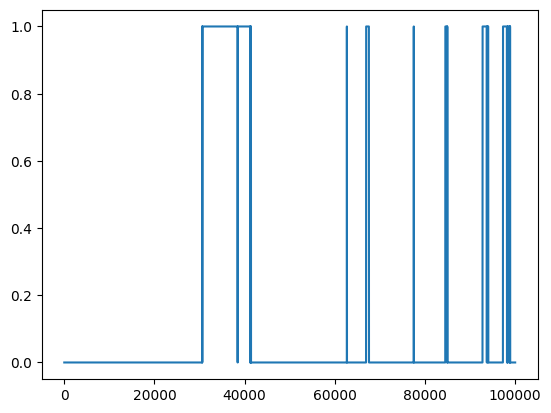

In [53]:
plt.plot(clusters_labels)